In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import pathlib
import pysam
import pyfaidx
import warnings
import re
import argparse
import sys
import subprocess
from tqdm import tqdm 

tqdm.pandas()
warnings.filterwarnings("ignore")

main_outptudir = "/workdir/outdir/pipeline_output"

analysis_output_version = "20250729"

name = "Vi"
# name = "Truong"

path_to_main_output = os.path.join(main_outptudir, "data_analysis", name, analysis_output_version)


rundf = pd.read_excel("../panel_design/All_panel_designs_20250601.xlsx", sheet_name="Runs_tracking")
rundf.columns = ["Run", "SampleID", "UMI", "Panel_version", "Name", "amplicon_name", "serial"]

# umi_rundf = rundf[(rundf["UMI"] == "Yes") & (rundf["Name"] == name) ]
umi_rundf = rundf[(rundf["Name"] == name) ]

collect_all_sample_sheets = [item for item in pathlib.Path("../experiments/").glob("SampleSheet_batch_*.csv")]

samplesheet = pd.DataFrame()
for file in collect_all_sample_sheets:
    df = pd.read_csv(file, sep=",")
    df["batch"] = file.name.replace(".csv", "")
    samplesheet = pd.concat([samplesheet, df], ignore_index=True)

samplesheet.columns = ["filename", "FASTQ1", "FASTQ2", "batch"]
# samplesheet["Run"] = samplesheet["FASTQ1"].apply(lambda x: x.split("/")[5] if x.split("/")[5] != "2025" else x.split("/")[6])
samplesheet["Run"] = samplesheet["FASTQ1"].apply(lambda x: [item for item in x.split("/") if item.startswith("R")][0] )
samplesheet["SampleID"] = samplesheet["filename"].apply(lambda x: x.split("_")[0].split("-")[1])
print(f"All available runs: {", ".join(sorted(samplesheet['Run'].unique()))}")

##### R7489
# selected_run = "R7489"
# UMI = False
# umt_distance = 0
# serial = False

# ##### R7512
# selected_run = "R7512"
# UMI = False
# umt_distance = 0
# serial = True

##### R7519
# selected_run = "R7519"
# UMI = False
# umt_distance = 0
# serial = True


##### Vi: R7519, R7532, R7554, R7561, R7568, R7611, R7575, R7590
##### Truong R7547, R7554, R7561
selected_run = "R7724"
UMI = False
umt_distance = 0
serial = True

if selected_run == "R7611":
    samplesheet = samplesheet[samplesheet["batch"] == "SampleSheet_batch_20250721"]

umi_rundf = umi_rundf[umi_rundf["Run"] == selected_run]
samplesheet = samplesheet[samplesheet["Run"] == selected_run]

path_to_02_output = os.path.join(path_to_main_output, "02_output", selected_run)
os.system(f"mkdir -p {path_to_02_output}")

All available runs: R7288, R7297, R7312, R7331, R7332, R7347, R7353, R7373, R7374, R7381, R7393, R7400, R7434, R7477, R7483, R7489, R7512, R7519, R7532, R7547, R7554, R7561, R7568, R7575, R7590, R7611, R7724


0

In [2]:
rundf

,Run,SampleID,UMI,Panel_version,Name,amplicon_name,serial
0,R6801,TM001,No,CRC_panel version 1.1,Vi,NaN,NaN
1,R6801,TM002,No,CRC_panel version 1.1,Vi,NaN,NaN
2,R6801,TM005,No,CRC_panel version 1.1,Vi,NaN,NaN
3,R6801,TM010,No,CRC_panel version 1.1,Vi,NaN,NaN
4,R6801,TM050,No,CRC_panel version 1.1,Vi,NaN,NaN
...,...,...,...,...,...,...,...
1073,R7724,TMSTS3V,No,DAPK1,Vi,DAPK1,S3
1074,R7724,TMSTS4V,No,DAPK1,Vi,DAPK1,S4
1075,R7724,TMSTS5V,No,DAPK1,Vi,DAPK1,S5
1076,R7724,TMSTS6V,No,DAPK1,Vi,DAPK1,S6


In [3]:
samplesheet

,filename,FASTQ1,FASTQ2,batch,Run,SampleID
710,10-TMSTS4V_S7561-S7761,/mnt/FASTQ/2025_2/R7724/zatm/10-TMSTS4V_S7561-...,/mnt/FASTQ/2025_2/R7724/zatm/10-TMSTS4V_S7561-...,SampleSheet_batch_20250803,R7724,TMSTS4V
711,11-TMSTS5V_S7562-S7762,/mnt/FASTQ/2025_2/R7724/zatm/11-TMSTS5V_S7562-...,/mnt/FASTQ/2025_2/R7724/zatm/11-TMSTS5V_S7562-...,SampleSheet_batch_20250803,R7724,TMSTS5V
712,12-TMSTS6V_S7563-S7763,/mnt/FASTQ/2025_2/R7724/zatm/12-TMSTS6V_S7563-...,/mnt/FASTQ/2025_2/R7724/zatm/12-TMSTS6V_S7563-...,SampleSheet_batch_20250803,R7724,TMSTS6V
713,13-TMSTS7V_S7564-S7764,/mnt/FASTQ/2025_2/R7724/zatm/13-TMSTS7V_S7564-...,/mnt/FASTQ/2025_2/R7724/zatm/13-TMSTS7V_S7564-...,SampleSheet_batch_20250803,R7724,TMSTS7V
714,1-TMSTS1P_S7551-S7751,/mnt/FASTQ/2025_2/R7724/zatm/1-TMSTS1P_S7551-S...,/mnt/FASTQ/2025_2/R7724/zatm/1-TMSTS1P_S7551-S...,SampleSheet_batch_20250803,R7724,TMSTS1P
715,2-TMSTS2P_S7552-S7752,/mnt/FASTQ/2025_2/R7724/zatm/2-TMSTS2P_S7552-S...,/mnt/FASTQ/2025_2/R7724/zatm/2-TMSTS2P_S7552-S...,SampleSheet_batch_20250803,R7724,TMSTS2P
716,3-TMSTS3P_S7553-S7753,/mnt/FASTQ/2025_2/R7724/zatm/3-TMSTS3P_S7553-S...,/mnt/FASTQ/2025_2/R7724/zatm/3-TMSTS3P_S7553-S...,SampleSheet_batch_20250803,R7724,TMSTS3P
717,4-TMSTS4P_S7554-S7754,/mnt/FASTQ/2025_2/R7724/zatm/4-TMSTS4P_S7554-S...,/mnt/FASTQ/2025_2/R7724/zatm/4-TMSTS4P_S7554-S...,SampleSheet_batch_20250803,R7724,TMSTS4P
718,5-TMSTS6P_S7556-S7756,/mnt/FASTQ/2025_2/R7724/zatm/5-TMSTS6P_S7556-S...,/mnt/FASTQ/2025_2/R7724/zatm/5-TMSTS6P_S7556-S...,SampleSheet_batch_20250803,R7724,TMSTS6P
719,6-TMSTS7P_S7557-S7757,/mnt/FASTQ/2025_2/R7724/zatm/6-TMSTS7P_S7557-S...,/mnt/FASTQ/2025_2/R7724/zatm/6-TMSTS7P_S7557-S...,SampleSheet_batch_20250803,R7724,TMSTS7P


In [4]:
rerun = True
if (os.path.isfile(os.path.join(path_to_02_output, f"UMI_runs_tracking_{selected_run}.xlsx")) == False) | (rerun  == True):
    umi_rundf["uniqueID"] = umi_rundf[["SampleID", "Run"]].apply(lambda x: f"{x[0]}_{x[1]}", axis=1)
    samplesheet["uniqueID"] = samplesheet[["SampleID", "Run"]].apply(lambda x: f"{x[0]}_{x[1]}", axis=1)

    final_umi_rundf = umi_rundf.merge(samplesheet.drop(["SampleID", "Run"], axis = 1), left_on = "uniqueID", right_on = "uniqueID")
    final_umi_rundf["UMI_cov_file"] = final_umi_rundf[["batch", "filename"]].apply(lambda x: os.path.join(
        main_outptudir, x[0], f"UMT_DISTANCE_{umt_distance}", "BISMARK_COV", f"{x[1]}.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov"
    ), axis = 1)
    final_umi_rundf["nonUMI_cov_file"] = final_umi_rundf[["batch", "filename"]].apply(lambda x: os.path.join(
        main_outptudir, x[0], f"UMT_DISTANCE_{umt_distance}", "BISMARK_COV", f"{x[1]}.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov"
    ), axis = 1)

    final_umi_rundf["check_nonUMI"] = final_umi_rundf["nonUMI_cov_file"].apply(lambda x: os.path.exists(x))

    final_umi_rundf["unmapped_bam"] = final_umi_rundf[["batch", "filename"]].apply(
        lambda x: os.path.join(main_outptudir, x[0], f"UMT_DISTANCE_{umt_distance}", "BISMARK_ALIGNMENT_UNMAPPED_BAM", f"{x[1]}_R1.UMIprocessed_bismark_bt2_pe.bam"), axis = 1
    )
    if UMI:
        final_umi_rundf["check_UMI"] = final_umi_rundf["UMI_cov_file"].apply(lambda x: os.path.exists(x))
    
        final_umi_rundf["connor_annotated"] = final_umi_rundf[["batch", "filename"]].apply(
            lambda x: os.path.join(main_outptudir, x[0], f"UMT_DISTANCE_{umt_distance}", "CONNOR_UMI_OUTPUT", f"{x[1]}.connor.fully_annotated.bam"), axis = 1
        )
        final_umi_rundf["connor_fastq"] = final_umi_rundf[["batch", "filename"]].apply(
            lambda x: os.path.join(main_outptudir, x[0], f"UMT_DISTANCE_{umt_distance}", "CONNOR_UMI_OUTPUT", f"{x[1]}.connor_R1.fastq.gz"), axis = 1
        )
        final_umi_rundf["umi_bam"] = final_umi_rundf[["batch", "filename"]].apply(
            lambda x: os.path.join(main_outptudir, x[0], f"UMT_DISTANCE_{umt_distance}", "BISMARK_ALIGNMENT", f"{x[1]}.connor_R1_bismark_bt2_pe.sorted.bam"), axis = 1
        )
        available_columns = ["unmapped_bam", "connor_annotated", "connor_fastq", "umi_bam", "non_umi_bam" , "UMI_cov_file"]
    
    if UMI == False:
        available_columns = ["unmapped_bam", "non_umi_bam"]
    final_umi_rundf["non_umi_bam"] = final_umi_rundf[["batch", "filename"]].apply(
        lambda x: os.path.join(main_outptudir, x[0], f"UMT_DISTANCE_{umt_distance}", "BISMARK_ALIGNMENT", f"{x[1]}.CutAdapt_R1_bismark_bt2_pe.sorted.bam"), axis = 1
    )

    tqdm.pandas()
    for col in available_columns:
        print(f"working on column: {col}")
        def _get_line_count(x):
            check_file = os.path.exists(x)
            x_raw = x.replace(".sorted.bam", ".bam")
            if check_file == False:
                if os.path.exists(x_raw) == True: 
                    # print(f"sorted bam file is not available, but raw bam file is available, sorting and indexing it now...")
                    os.system(f"samtools sort -@ 15 {x_raw} -o {x}")
                    os.system(f"samtools index {x}")
                else:
                    # rint(f"File {x} does not exist, skipping line count for this file.")
                    return 0
            if ".bam" in x:
                result = subprocess.run(f"samtools view {x} -c", shell=True, capture_output=True, text=True)
            elif ".fastq.gz" in x:
                result = subprocess.run(f"zcat {x} | wc -l", shell=True, capture_output=True, text=True)
            else:
                result = subprocess.run(f"cat {x} | wc -l", shell=True, capture_output=True, text=True)
            return int(result.stdout.strip())
            
        final_umi_rundf[f"count_{col}"] = final_umi_rundf[col].progress_apply(_get_line_count)    
    # small size fastq
    final_umi_rundf["small_FASTQ_size"] = final_umi_rundf["FASTQ1"].apply(lambda x: "smallsize" in x)
    final_umi_rundf.groupby("small_FASTQ_size")["SampleID"].count()
    final_umi_rundf.to_excel(os.path.join(path_to_02_output, f"UMI_runs_tracking_{selected_run}.xlsx"), index=False)
else:
    print("reading in saved processed UMI runs tracking file...")
    final_umi_rundf = pd.read_excel(os.path.join(path_to_02_output, f"UMI_runs_tracking_{selected_run}.xlsx"))

working on column: unmapped_bam


100%|██████████| 13/13 [00:00<00:00, 25479.42it/s]


working on column: non_umi_bam


  0%|          | 0/13 [00:00<?, ?it/s]samtools: /home/hieunguyen/miniconda3/envs/nextflow_dev/bin/../lib/libtinfow.so.6: no version information available (required by samtools)
samtools: /home/hieunguyen/miniconda3/envs/nextflow_dev/bin/../lib/libncursesw.so.6: no version information available (required by samtools)
samtools: /home/hieunguyen/miniconda3/envs/nextflow_dev/bin/../lib/libncursesw.so.6: no version information available (required by samtools)
[bam_sort_core] merging from 0 files and 15 in-memory blocks...
samtools: /home/hieunguyen/miniconda3/envs/nextflow_dev/bin/../lib/libtinfow.so.6: no version information available (required by samtools)
samtools: /home/hieunguyen/miniconda3/envs/nextflow_dev/bin/../lib/libncursesw.so.6: no version information available (required by samtools)
samtools: /home/hieunguyen/miniconda3/envs/nextflow_dev/bin/../lib/libncursesw.so.6: no version information available (required by samtools)
 15%|█▌        | 2/13 [00:00<00:05,  2.17it/s]samtools: 

In [5]:
umi_rundf

,Run,SampleID,UMI,Panel_version,Name,amplicon_name,serial,uniqueID
1065,R7724,TMSTS1P,No,DAPK1,Vi,DAPK1,S1,TMSTS1P_R7724
1066,R7724,TMSTS2P,No,DAPK1,Vi,DAPK1,S2,TMSTS2P_R7724
1067,R7724,TMSTS3P,No,DAPK1,Vi,DAPK1,S3,TMSTS3P_R7724
1068,R7724,TMSTS4P,No,DAPK1,Vi,DAPK1,S4,TMSTS4P_R7724
1069,R7724,TMSTS6P,No,DAPK1,Vi,DAPK1,S6,TMSTS6P_R7724
1070,R7724,TMSTS7P,No,DAPK1,Vi,DAPK1,S7,TMSTS7P_R7724
1071,R7724,TMSTS1V,No,DAPK1,Vi,DAPK1,S1,TMSTS1V_R7724
1072,R7724,TMSTS2V,No,DAPK1,Vi,DAPK1,S2,TMSTS2V_R7724
1073,R7724,TMSTS3V,No,DAPK1,Vi,DAPK1,S3,TMSTS3V_R7724
1074,R7724,TMSTS4V,No,DAPK1,Vi,DAPK1,S4,TMSTS4V_R7724


In [6]:
samplesheet

,filename,FASTQ1,FASTQ2,batch,Run,SampleID,uniqueID
710,10-TMSTS4V_S7561-S7761,/mnt/FASTQ/2025_2/R7724/zatm/10-TMSTS4V_S7561-...,/mnt/FASTQ/2025_2/R7724/zatm/10-TMSTS4V_S7561-...,SampleSheet_batch_20250803,R7724,TMSTS4V,TMSTS4V_R7724
711,11-TMSTS5V_S7562-S7762,/mnt/FASTQ/2025_2/R7724/zatm/11-TMSTS5V_S7562-...,/mnt/FASTQ/2025_2/R7724/zatm/11-TMSTS5V_S7562-...,SampleSheet_batch_20250803,R7724,TMSTS5V,TMSTS5V_R7724
712,12-TMSTS6V_S7563-S7763,/mnt/FASTQ/2025_2/R7724/zatm/12-TMSTS6V_S7563-...,/mnt/FASTQ/2025_2/R7724/zatm/12-TMSTS6V_S7563-...,SampleSheet_batch_20250803,R7724,TMSTS6V,TMSTS6V_R7724
713,13-TMSTS7V_S7564-S7764,/mnt/FASTQ/2025_2/R7724/zatm/13-TMSTS7V_S7564-...,/mnt/FASTQ/2025_2/R7724/zatm/13-TMSTS7V_S7564-...,SampleSheet_batch_20250803,R7724,TMSTS7V,TMSTS7V_R7724
714,1-TMSTS1P_S7551-S7751,/mnt/FASTQ/2025_2/R7724/zatm/1-TMSTS1P_S7551-S...,/mnt/FASTQ/2025_2/R7724/zatm/1-TMSTS1P_S7551-S...,SampleSheet_batch_20250803,R7724,TMSTS1P,TMSTS1P_R7724
715,2-TMSTS2P_S7552-S7752,/mnt/FASTQ/2025_2/R7724/zatm/2-TMSTS2P_S7552-S...,/mnt/FASTQ/2025_2/R7724/zatm/2-TMSTS2P_S7552-S...,SampleSheet_batch_20250803,R7724,TMSTS2P,TMSTS2P_R7724
716,3-TMSTS3P_S7553-S7753,/mnt/FASTQ/2025_2/R7724/zatm/3-TMSTS3P_S7553-S...,/mnt/FASTQ/2025_2/R7724/zatm/3-TMSTS3P_S7553-S...,SampleSheet_batch_20250803,R7724,TMSTS3P,TMSTS3P_R7724
717,4-TMSTS4P_S7554-S7754,/mnt/FASTQ/2025_2/R7724/zatm/4-TMSTS4P_S7554-S...,/mnt/FASTQ/2025_2/R7724/zatm/4-TMSTS4P_S7554-S...,SampleSheet_batch_20250803,R7724,TMSTS4P,TMSTS4P_R7724
718,5-TMSTS6P_S7556-S7756,/mnt/FASTQ/2025_2/R7724/zatm/5-TMSTS6P_S7556-S...,/mnt/FASTQ/2025_2/R7724/zatm/5-TMSTS6P_S7556-S...,SampleSheet_batch_20250803,R7724,TMSTS6P,TMSTS6P_R7724
719,6-TMSTS7P_S7557-S7757,/mnt/FASTQ/2025_2/R7724/zatm/6-TMSTS7P_S7557-S...,/mnt/FASTQ/2025_2/R7724/zatm/6-TMSTS7P_S7557-S...,SampleSheet_batch_20250803,R7724,TMSTS7P,TMSTS7P_R7724


# helper functions

In [7]:
# panel_name = "Lung_panel version 1.1"
# cpgdf = pd.DataFrame()
# panel_name = panel_name.replace(" ", "_")
# paneldf = pd.read_excel("../panel_design/All_panel_designs_20250601.xlsx", sheet_name=panel_name)
# paneldf[f"{genome_version}_org"] = paneldf[genome_version].values
# paneldf["lengthF"] = paneldf["Forward Primer Seq"].apply(lambda x: len(x))
# paneldf["lengthR"] = paneldf["Reverse Primer Seq"].apply(lambda x: len(x))

def _remove_primer_coords(x, lenF, lenR):
    chrom = x.split(":")[0]
    start = int(x.split(":")[1].split("-")[0])
    end = int(x.split(":")[1].split("-")[1])
    start = start + lenF - 1
    end = end - lenR + 1
    return f"{chrom}:{start}-{end}"

def get_refseq(path_to_all_fa, chrom, start, end):
        refseq = pyfaidx.Fasta(os.path.join(path_to_all_fa, "{}.fa".format(chrom)))
        return(str.upper(refseq.get_seq(name = "{}".format(chrom), start = start, end = end).seq))

path_to_all_fa = "/home/hieunguyen/resources/hg19"
genome_version = "hg19"

##### get list of all real cpg for this panel
all_cpgdf = dict()
all_cpgdf_with_primer = dict()
all_paneldf = dict()
for panel_name in tqdm(final_umi_rundf.Panel_version.unique()):
    
    panel_name = panel_name.replace(" ", "_")
    paneldf = pd.read_excel("../panel_design/All_panel_designs_20250601.xlsx", sheet_name=panel_name)
    paneldf[f"{genome_version}_org"] = paneldf[genome_version].values
    paneldf["lengthF"] = paneldf["Forward Primer Seq"].apply(lambda x: len(x))
    paneldf["lengthR"] = paneldf["Reverse Primer Seq"].apply(lambda x: len(x))
    paneldf[genome_version] = paneldf[[genome_version, "lengthF", "lengthR"]].apply(lambda x:_remove_primer_coords(x[0], x[1], x[2]), axis = 1)

    def generate_cpgdf(region_col, paneldf):
        outputdf = pd.DataFrame()
        print(f"working on panel: {panel_name}, with {len(paneldf[region_col].unique())} regions")
        for region in paneldf[region_col].unique():
            region_name = paneldf[paneldf[region_col] == region]["Amplicon"].values[0]
            chrom = region.split(":")[0].replace("Chr", "chr").replace("chr", "")
            start = int(region.split(":")[1].split("-")[0])
            end = int(region.split(":")[1].split("-")[1])
            refseq = pyfaidx.Fasta(os.path.join(path_to_all_fa, "chr{}.fa".format(chrom)))
            refseq_at_region = str.upper(refseq.get_seq(name = "chr{}".format(chrom), start = start, end = end).seq)

            all_cpg_in_cluster = [m.start(0) for m in re.finditer("CG", refseq_at_region)]
            cpg_coords = [f"chr{chrom}:{item + start}-{item + start + 1}" for item in all_cpg_in_cluster]

            tmp_outputdf = pd.DataFrame(data = cpg_coords, columns = ["CpG"])
            tmp_outputdf["region"] = region
            tmp_outputdf["region_name"] = region_name
            outputdf = pd.concat([outputdf, tmp_outputdf], axis = 0)
        print(f"outputdf shape after adding region {region}: {outputdf.shape}")
        return outputdf
    
    cpgdf = generate_cpgdf(genome_version, paneldf)
    cpgdf_with_primer = generate_cpgdf(f"{genome_version}_org", paneldf)
    
    cpgdf = cpgdf[["region", "CpG", "region_name"]]
    all_cpgdf[panel_name] = cpgdf.copy()

    cpgdf_with_primer = cpgdf_with_primer[["region", "CpG", "region_name"]]
    all_cpgdf_with_primer[panel_name] = cpgdf_with_primer.copy()

    all_paneldf[panel_name] = paneldf.copy()

# for i in all_cpgdf.keys():
#     tmpdf1 = all_cpgdf[i].copy()
#     tmpdf2 = all_cpgdf_with_primer[i].copy()
#     assert tmpdf1.shape[0] == tmpdf2.shape[0], f"Error: {i} cpgdf and cpgdf_with_primer have different number of rows"


100%|██████████| 1/1 [00:00<00:00, 40.45it/s]

working on panel: DAPK1, with 1 regions
outputdf shape after adding region chr9:90112497-90112713: (31, 3)
working on panel: DAPK1, with 1 regions
outputdf shape after adding region chr9:90112470-90112737: (32, 3)


In [8]:
paneldf

,Amplicon,hg38,hg19,Forward Primer Seq,Reverse Primer Seq,hg19_org,lengthF,lengthR
0,DAPK1,chr9:87497555-87497822,chr9:90112497-90112713,TAGAATTTAGTTAGAGGGTAGTTTAGTA,AAACRACCAATAAAAACCCTACAAA,chr9:90112470-90112737,28,25


In [9]:

def generate_cov(input_cov_file, panel_name, sampleid, outputdir):
    os.system(f"mkdir -p {outputdir}")
    if os.path.exists(input_cov_file) == False:
        print(f"Input coverage file {input_cov_file} does not exist, skipping...")
        covdf = pd.DataFrame(columns=["chrom", "start", "end", "meth_density", "countC", "countT", "seq", "strand", "CpG", "check_context", "amplicon"])
        status = "File not available"
    else:
        print(f"Processing {input_cov_file} for panel {panel_name}...")
        # get list of CpG which are not in primer regions
        cpgdf = all_cpgdf[panel_name]
        covdf = pd.read_csv(input_cov_file, header = None, sep = "\t")
        covdf.columns = ["chrom", "start", "end", "meth_density", "countC", "countT"]
        if covdf.shape[0] != 0:
            covdf = covdf[covdf["chrom"].isin(["chrX", "chrY", "chrMT", "chrM"]) == False]
            covdf = covdf[covdf["chrom"].str.contains("chrUn") == False]
            covdf = covdf[covdf["chrom"].str.contains("_") == False]
            covdf["seq"] = covdf[["chrom", "start"]].progress_apply(lambda x: get_refseq(path_to_all_fa= path_to_all_fa, 
                                                                    chrom = x[0], start = x[1], end = x[1] + 1), axis = 1)
            covdf["strand"] = covdf["seq"].apply(lambda x: "+" if x != "CG" else "-")
            covdf_raw = covdf.copy()
            covdf["start"] = covdf[["seq", "start"]].apply(lambda x: x[1] + 1 if x[0] != "CG" else x[1], axis = 1)

            covdf["chrom"] = covdf["chrom"].apply(lambda x: str(x))
            covdf["CpG"] = covdf[["chrom", "start"]].apply(lambda x: f"{str(x[0])}:{x[1]}-{x[1] + 1}", axis = 1)
            covdf["check_context"] = covdf["CpG"].apply(lambda x: "CpG_context" if x in cpgdf["CpG"].values else "False")
            covdf["amplicon"] = covdf["CpG"].apply(lambda x: cpgdf[cpgdf["CpG"] == x]["region_name"].values[0] if x in cpgdf["CpG"].values else "NA")
            status = "Processed"
        else:
            print(f"Coverage file {input_cov_file} is empty, skipping...")
            covdf = pd.DataFrame(columns=["chrom", "start", "end", "meth_density", "countC", "countT", "seq", "strand", "CpG", "check_context", "amplicon"])
            status = "Empty file"
        covdf.to_excel(os.path.join(outputdir, f"{sampleid}.xlsx"))
    return status, os.path.join(outputdir, f"{sampleid}.xlsx")

# mode = "UMI"  # or "ignore_UMI"
if UMI == True:
    input_modes = ["UMI", "ignore_UMI"]
else:
    input_modes = ["ignore_UMI"]
for mode in input_modes: 
    all_status = []
    all_finished_path = []
    for j in range(final_umi_rundf.shape[0]):
        panel_name = final_umi_rundf.Panel_version.values[j].replace(" ", "_")
        run = final_umi_rundf.Run.values[j]
        sampleid = final_umi_rundf.SampleID.values[j]
        if mode == "UMI":
            input_cov_file = final_umi_rundf.UMI_cov_file.values[j]
        elif mode == "ignore_UMI":
            input_cov_file = final_umi_rundf.nonUMI_cov_file.values[j]

        outputdir = os.path.join(path_to_02_output, "cov", run, panel_name, mode)
        status, output_cov_path = generate_cov(input_cov_file=input_cov_file, panel_name=panel_name, sampleid=sampleid, outputdir=outputdir)
        all_status.append(status)
        all_finished_path.append(output_cov_path)
    final_umi_rundf[f"{mode}_status"] = all_status
    final_umi_rundf[f"{mode}_processed_cov"] = all_finished_path

Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250803/UMT_DISTANCE_0/BISMARK_COV/1-TMSTS1P_S7551-S7751.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel DAPK1...


100%|██████████| 40/40 [00:00<00:00, 8518.52it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250803/UMT_DISTANCE_0/BISMARK_COV/2-TMSTS2P_S7552-S7752.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel DAPK1...


100%|██████████| 55/55 [00:00<00:00, 3997.83it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250803/UMT_DISTANCE_0/BISMARK_COV/3-TMSTS3P_S7553-S7753.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel DAPK1...


100%|██████████| 40/40 [00:00<00:00, 8360.18it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250803/UMT_DISTANCE_0/BISMARK_COV/4-TMSTS4P_S7554-S7754.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel DAPK1...


100%|██████████| 41/41 [00:00<00:00, 9857.64it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250803/UMT_DISTANCE_0/BISMARK_COV/5-TMSTS6P_S7556-S7756.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel DAPK1...


100%|██████████| 52/52 [00:00<00:00, 6899.18it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250803/UMT_DISTANCE_0/BISMARK_COV/6-TMSTS7P_S7557-S7757.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel DAPK1...


100%|██████████| 46/46 [00:00<00:00, 8850.77it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250803/UMT_DISTANCE_0/BISMARK_COV/7-TMSTS1V_S7558-S7758.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel DAPK1...


100%|██████████| 48/48 [00:00<00:00, 5678.37it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250803/UMT_DISTANCE_0/BISMARK_COV/8-TMSTS2V_S7559-S7759.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel DAPK1...


100%|██████████| 96/96 [00:00<00:00, 4866.25it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250803/UMT_DISTANCE_0/BISMARK_COV/9-TMSTS3V_S7560-S7760.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel DAPK1...


100%|██████████| 155/155 [00:00<00:00, 4902.73it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250803/UMT_DISTANCE_0/BISMARK_COV/10-TMSTS4V_S7561-S7761.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel DAPK1...


100%|██████████| 70/70 [00:00<00:00, 5581.99it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250803/UMT_DISTANCE_0/BISMARK_COV/11-TMSTS5V_S7562-S7762.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel DAPK1...


100%|██████████| 67/67 [00:00<00:00, 5466.22it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250803/UMT_DISTANCE_0/BISMARK_COV/12-TMSTS6V_S7563-S7763.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel DAPK1...


100%|██████████| 46/46 [00:00<00:00, 6813.50it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250803/UMT_DISTANCE_0/BISMARK_COV/13-TMSTS7V_S7564-S7764.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel DAPK1...


100%|██████████| 331/331 [00:00<00:00, 4464.87it/s]


In [10]:
final_umi_rundf[final_umi_rundf["small_FASTQ_size"] == True]

,Run,SampleID,UMI,Panel_version,Name,amplicon_name,serial,uniqueID,filename,FASTQ1,...,UMI_cov_file,nonUMI_cov_file,check_nonUMI,unmapped_bam,non_umi_bam,count_unmapped_bam,count_non_umi_bam,small_FASTQ_size,ignore_UMI_status,ignore_UMI_processed_cov


In [11]:
# run = "R7288"
# mode = "UMI"  # or "ignore_UMI"

if serial:
    for run in final_umi_rundf.Run.unique():
    # for run in ["R7400"]:
        if UMI == True:
            input_modes = ["UMI", "ignore_UMI"]
        else:
            input_modes = ["ignore_UMI"]
        for mode in input_modes:
            if mode == "UMI":
                plot_metadata = final_umi_rundf[(final_umi_rundf["Run"] == run) & 
                                                (final_umi_rundf["UMI_status"] == "Processed")].sort_values(by = "SampleID")
                selected_cov = "UMI_processed_cov"
            else:
                plot_metadata = final_umi_rundf[(final_umi_rundf["Run"] == run) & 
                                                (final_umi_rundf["ignore_UMI_status"] == "Processed")].sort_values(by = "SampleID")
                selected_cov = "ignore_UMI_processed_cov"

            run_panels = plot_metadata.Panel_version.unique()

            # check how many panels are available for this run
            print(f"Run {run} has {len(plot_metadata.Panel_version.unique())} panel(s), {', '.join(run_panels)}")

            for panel_name in run_panels:
                panel_name = panel_name.replace(" ", "_")
                cpgdf = all_cpgdf[panel_name].copy()
                paneldf = all_paneldf[panel_name].copy()

                for amplicon in plot_metadata[plot_metadata["amplicon_name"].isna() == False]["amplicon_name"].unique():
                    tmp_metadata = plot_metadata[plot_metadata["amplicon_name"] == amplicon].sort_values(by = "serial")
                    if "," in amplicon:
                        covdf = pd.DataFrame(data = cpgdf[cpgdf["region_name"].isin(amplicon.replace(" ", "").split(","))]["CpG"].values, columns = ["CpG"])
                    else:
                        covdf = pd.DataFrame(data = cpgdf[cpgdf["region_name"] == amplicon]["CpG"].values, columns = ["CpG"])
                        
                    os.system(f"mkdir -p {os.path.join(path_to_02_output, 
                                                    "S1_to_S5_in_amplicons", 
                                                    run,
                                                    panel_name, 
                                                    mode)}")
                    if tmp_metadata.shape[0] > 1:
                        if "," in amplicon:
                            amplicon = amplicon.replace(",", "-").replace(" ", "")
                        for i in range(tmp_metadata.shape[0]):
                            p = tmp_metadata.iloc[i][selected_cov]
                            sample  = tmp_metadata.iloc[i]["serial"]
                            tmp_covdf = pd.read_excel(p)[["CpG", "meth_density"]]
                            tmp_covdf.columns = ["CpG", f"{amplicon}_{sample}"]
                            covdf = covdf.merge(tmp_covdf, right_on = "CpG", left_on = "CpG")
                        if covdf.shape[0] > 1:
                            plt.figure(figsize=(12, 6))
                            covdf.set_index("CpG").T.plot.line()
                            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
                            plt.xticks(rotation=90)
                            plt.tight_layout()
                            plt.title(f"Methylation Density in {amplicon} Amplicon, {mode} \n Samples: {', '.join(tmp_metadata['serial'].unique())}")
                            plt.savefig(os.path.join(path_to_02_output, 
                                                    "S1_to_S5_in_amplicons", 
                                                    run,
                                                    panel_name, 
                                                    mode,
                                                    f"{amplicon}_methylation_density.png"),
                                                    dpi=300, 
                                                    bbox_inches='tight')

                            ######
                            # corr_plotdf = covdf.set_index("CpG").mean(axis = 0).reset_index()
                            # corr_plotdf.columns = ["CpG", "mean_meth_density"]
                            # corr_plotdf["true_meth"] = [0, 5, 10, 50, 100]

                            # plt.figure(figsize=(6, 6))
                            # sns.scatterplot(data = corr_plotdf, x = "true_meth", y = "mean_meth_density")
                            # corr = corr_plotdf[["true_meth", "mean_meth_density"]].corr().iloc[0,1]
                            # plt.text(60, 10, f"Pearson r = {corr:.2f}", fontsize=14)
                            # plt.plot([0, 100], [0, 100], 'r--')
                            # plt.xlabel("Expected methylation S1-S5 (%)")
                            # plt.ylabel("Observed mean methylation density")
                            # plt.title("Correlation between true and observed methylation (%)")
                            # plt.tight_layout()
                            # plt.savefig(os.path.join(path_to_02_output, 
                            #                         "S1_to_S5_in_amplicons", 
                            #                         run,
                            #                         panel_name, 
                            #                         mode,
                            #                         f"{amplicon}_correlation.png"), 
                            #                         dpi=300, 
                            #                         bbox_inches='tight')
                            # plt.show()


Run R7724 has 1 panel(s), DAPK1


In [12]:
plot_metadata

,Run,SampleID,UMI,Panel_version,Name,amplicon_name,serial,uniqueID,filename,FASTQ1,...,UMI_cov_file,nonUMI_cov_file,check_nonUMI,unmapped_bam,non_umi_bam,count_unmapped_bam,count_non_umi_bam,small_FASTQ_size,ignore_UMI_status,ignore_UMI_processed_cov
0,R7724,TMSTS1P,No,DAPK1,Vi,DAPK1,S1,TMSTS1P_R7724,1-TMSTS1P_S7551-S7751,/mnt/FASTQ/2025_2/R7724/zatm/1-TMSTS1P_S7551-S...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,True,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,0,513050,False,Processed,/workdir/outdir/pipeline_output/data_analysis/...
6,R7724,TMSTS1V,No,DAPK1,Vi,DAPK1,S1,TMSTS1V_R7724,7-TMSTS1V_S7558-S7758,/mnt/FASTQ/2025_2/R7724/zatm/7-TMSTS1V_S7558-S...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,True,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,0,2366,False,Processed,/workdir/outdir/pipeline_output/data_analysis/...
1,R7724,TMSTS2P,No,DAPK1,Vi,DAPK1,S2,TMSTS2P_R7724,2-TMSTS2P_S7552-S7752,/mnt/FASTQ/2025_2/R7724/zatm/2-TMSTS2P_S7552-S...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,True,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,0,447428,False,Processed,/workdir/outdir/pipeline_output/data_analysis/...
7,R7724,TMSTS2V,No,DAPK1,Vi,DAPK1,S2,TMSTS2V_R7724,8-TMSTS2V_S7559-S7759,/mnt/FASTQ/2025_2/R7724/zatm/8-TMSTS2V_S7559-S...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,True,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,0,88662,False,Processed,/workdir/outdir/pipeline_output/data_analysis/...
2,R7724,TMSTS3P,No,DAPK1,Vi,DAPK1,S3,TMSTS3P_R7724,3-TMSTS3P_S7553-S7753,/mnt/FASTQ/2025_2/R7724/zatm/3-TMSTS3P_S7553-S...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,True,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,0,279190,False,Processed,/workdir/outdir/pipeline_output/data_analysis/...
8,R7724,TMSTS3V,No,DAPK1,Vi,DAPK1,S3,TMSTS3V_R7724,9-TMSTS3V_S7560-S7760,/mnt/FASTQ/2025_2/R7724/zatm/9-TMSTS3V_S7560-S...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,True,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,0,291844,False,Processed,/workdir/outdir/pipeline_output/data_analysis/...
3,R7724,TMSTS4P,No,DAPK1,Vi,DAPK1,S4,TMSTS4P_R7724,4-TMSTS4P_S7554-S7754,/mnt/FASTQ/2025_2/R7724/zatm/4-TMSTS4P_S7554-S...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,True,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,0,1358778,False,Processed,/workdir/outdir/pipeline_output/data_analysis/...
9,R7724,TMSTS4V,No,DAPK1,Vi,DAPK1,S4,TMSTS4V_R7724,10-TMSTS4V_S7561-S7761,/mnt/FASTQ/2025_2/R7724/zatm/10-TMSTS4V_S7561-...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,True,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,0,175248,False,Processed,/workdir/outdir/pipeline_output/data_analysis/...
10,R7724,TMSTS5V,No,DAPK1,Vi,DAPK1,S5,TMSTS5V_R7724,11-TMSTS5V_S7562-S7762,/mnt/FASTQ/2025_2/R7724/zatm/11-TMSTS5V_S7562-...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,True,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,0,34808,False,Processed,/workdir/outdir/pipeline_output/data_analysis/...
4,R7724,TMSTS6P,No,DAPK1,Vi,DAPK1,S6,TMSTS6P_R7724,5-TMSTS6P_S7556-S7756,/mnt/FASTQ/20

Run R7724 has 1 panel(s), DAPK1


100%|██████████| 1/1 [00:12<00:00, 12.58s/it]


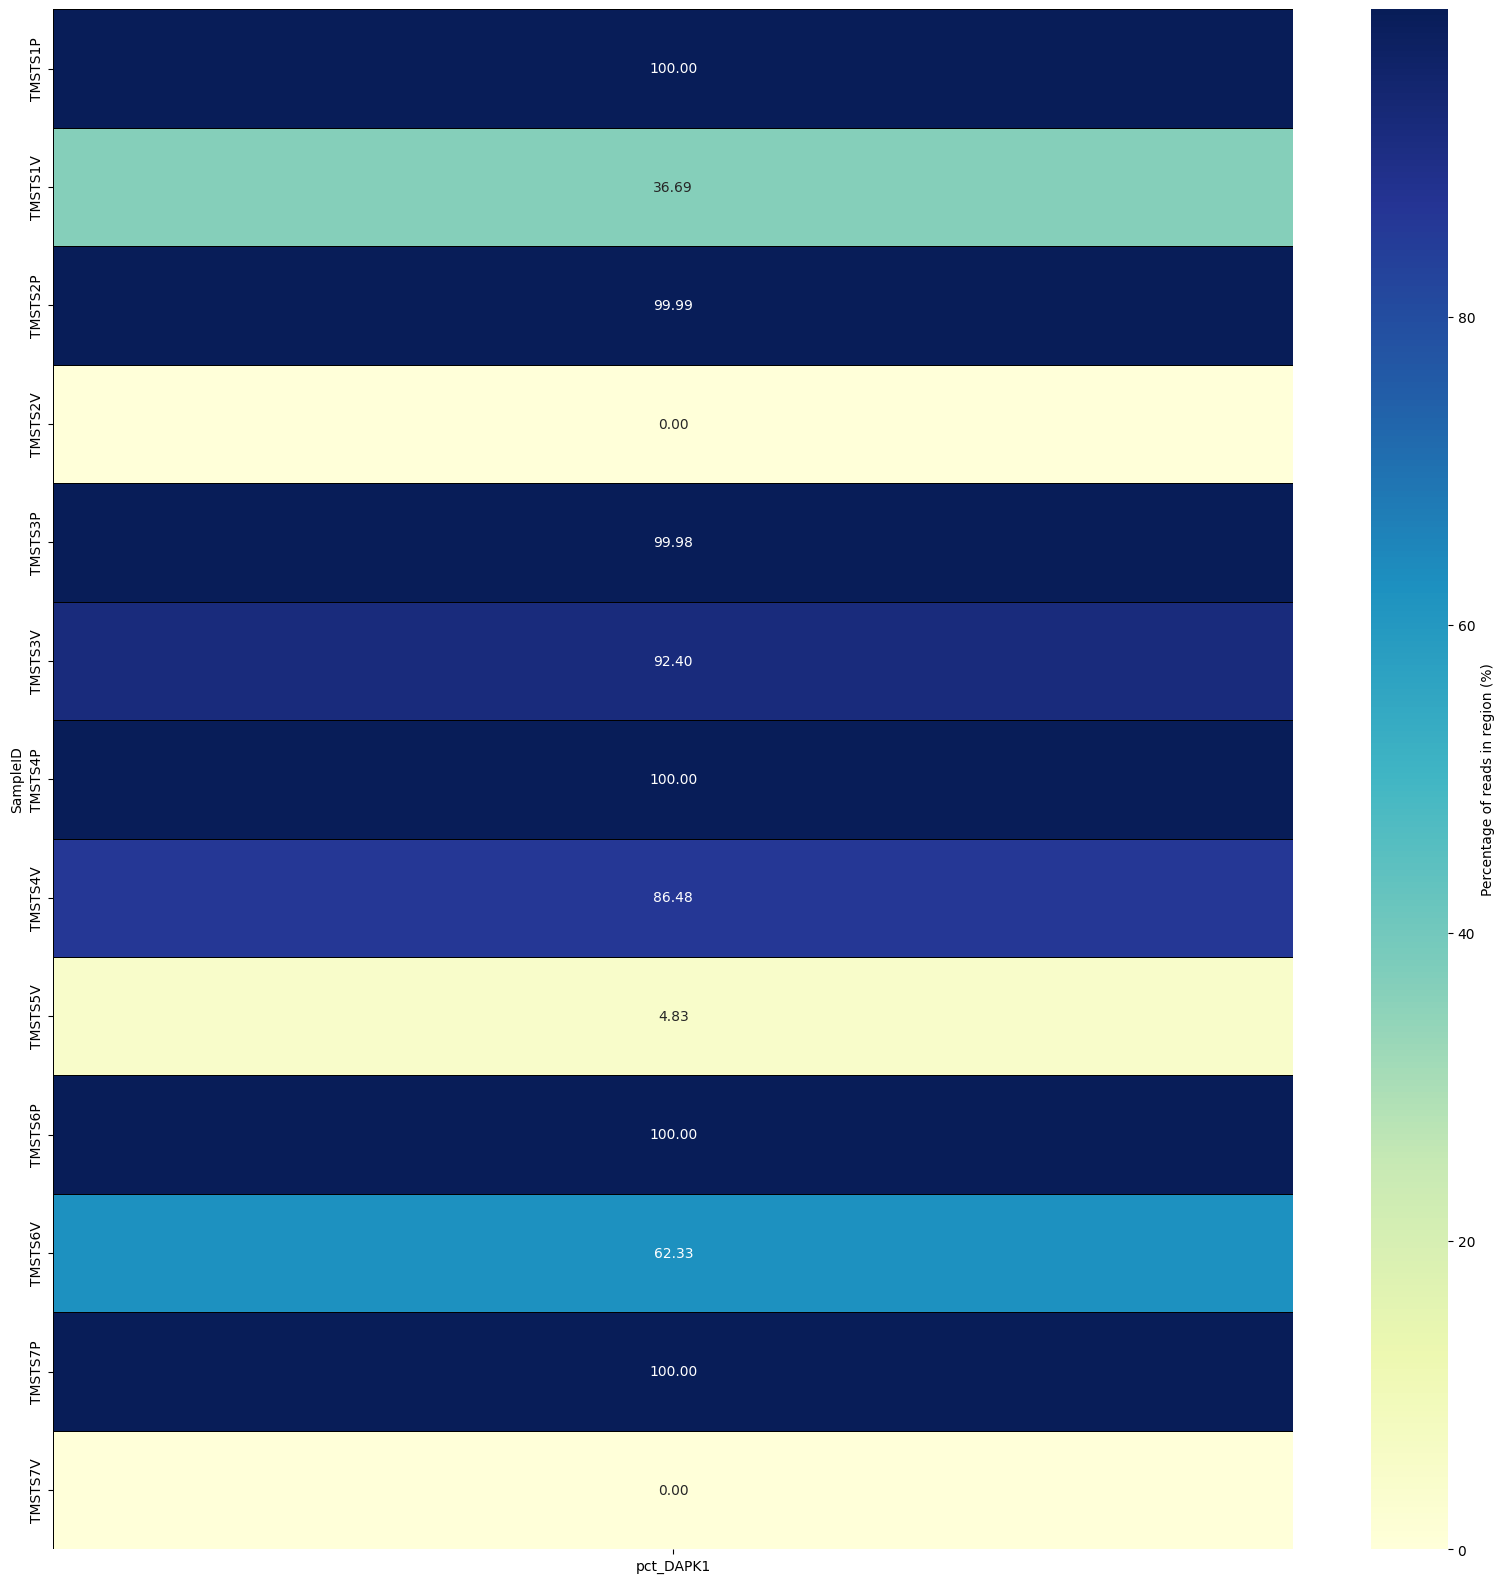

In [13]:
###### count on/off target reads
def count_read_in_region(bam_path, region, chr_mode = False):
    all_reads = []
    bamfile = pysam.AlignmentFile(bam_path, "rb")
    if chr_mode:
        region = f"chr{region}"
    fetched_obj = bamfile.fetch(region = region)
    for read in fetched_obj:
        all_reads.append(read)
    return(len(all_reads))

# if serial:
for run in final_umi_rundf.Run.unique():
    if UMI == True:
            input_modes = ["UMI", "ignore_UMI"]
    else:
        input_modes = ["ignore_UMI"]
    for mode in input_modes:
        if mode == "UMI":
            plot_metadata = final_umi_rundf[(final_umi_rundf["Run"] == run) & 
                                            (final_umi_rundf["UMI_status"] == "Processed")].sort_values(by = "SampleID")
            selected_cov = "UMI_processed_cov"
            bampath = "umi_bam"
            total_col = "count_umi_bam"
        else:
            plot_metadata = final_umi_rundf[(final_umi_rundf["Run"] == run) & 
                                            (final_umi_rundf["ignore_UMI_status"] == "Processed")].sort_values(by = "SampleID")
            selected_cov = "ignore_UMI_processed_cov"
            bampath = "non_umi_bam"
            total_col = "count_non_umi_bam"

        run_panels = plot_metadata.Panel_version.unique()

        # check how many panels are available for this run
        print(f"Run {run} has {len(plot_metadata.Panel_version.unique())} panel(s), {', '.join(run_panels)}")
        
        for panel_name in run_panels:
            tmp_metadata = plot_metadata[plot_metadata["Panel_version"] == panel_name].sort_values(by = ["amplicon_name", "serial"])
            
            panel_name = panel_name.replace(" ", "_")
            paneldf = all_paneldf[panel_name].copy()
            os.system(f"mkdir -p {os.path.join(path_to_02_output, 
                                                "count_reads_in_regions", 
                                                run,
                                                panel_name, 
                                                mode)}")
            for bam_region in tqdm(paneldf[genome_version].unique()):
                region_name = paneldf[paneldf[genome_version] == bam_region]["Amplicon"].values[0]
                tmp_metadata[f"count_{region_name}"] = tmp_metadata[bampath].apply(lambda x: count_read_in_region(x, bam_region))
                tmp_metadata[f"pct_{region_name}"] = tmp_metadata[f"count_{region_name}"] / tmp_metadata[total_col] * 100
            
        tmp_metadata.to_excel(os.path.join(path_to_02_output, 
                                            "count_reads_in_regions", 
                                            run,
                                            panel_name, 
                                            mode,
                                            f"{run}_{panel_name}.xlsx"), index = False)
        plotdf = tmp_metadata.sort_values(by = "amplicon_name")[[item for item in tmp_metadata.columns if "pct_" in item] + ["SampleID"]].sort_values(by = "SampleID").set_index("SampleID")
        plt.figure(figsize=(20, 20))
        plt.tight_layout()
        sns.heatmap(plotdf,cmap="YlGnBu", fmt=".2f", annot=True, linewidths=.5, linecolor='black', cbar_kws={"label": "Percentage of reads in region (%)"})
        plt.savefig(os.path.join(path_to_02_output, 
                                            "count_reads_in_regions", 
                                            run,
                                            panel_name, 
                                            mode,
                                            f"{run}_{panel_name}.png"), dpi=300, bbox_inches='tight')


In [14]:
run_panels

array(['DAPK1'], dtype=object)

Run R7724 has 1 panel(s), DAPK1


100%|██████████| 13/13 [00:00<00:00, 42.02it/s]


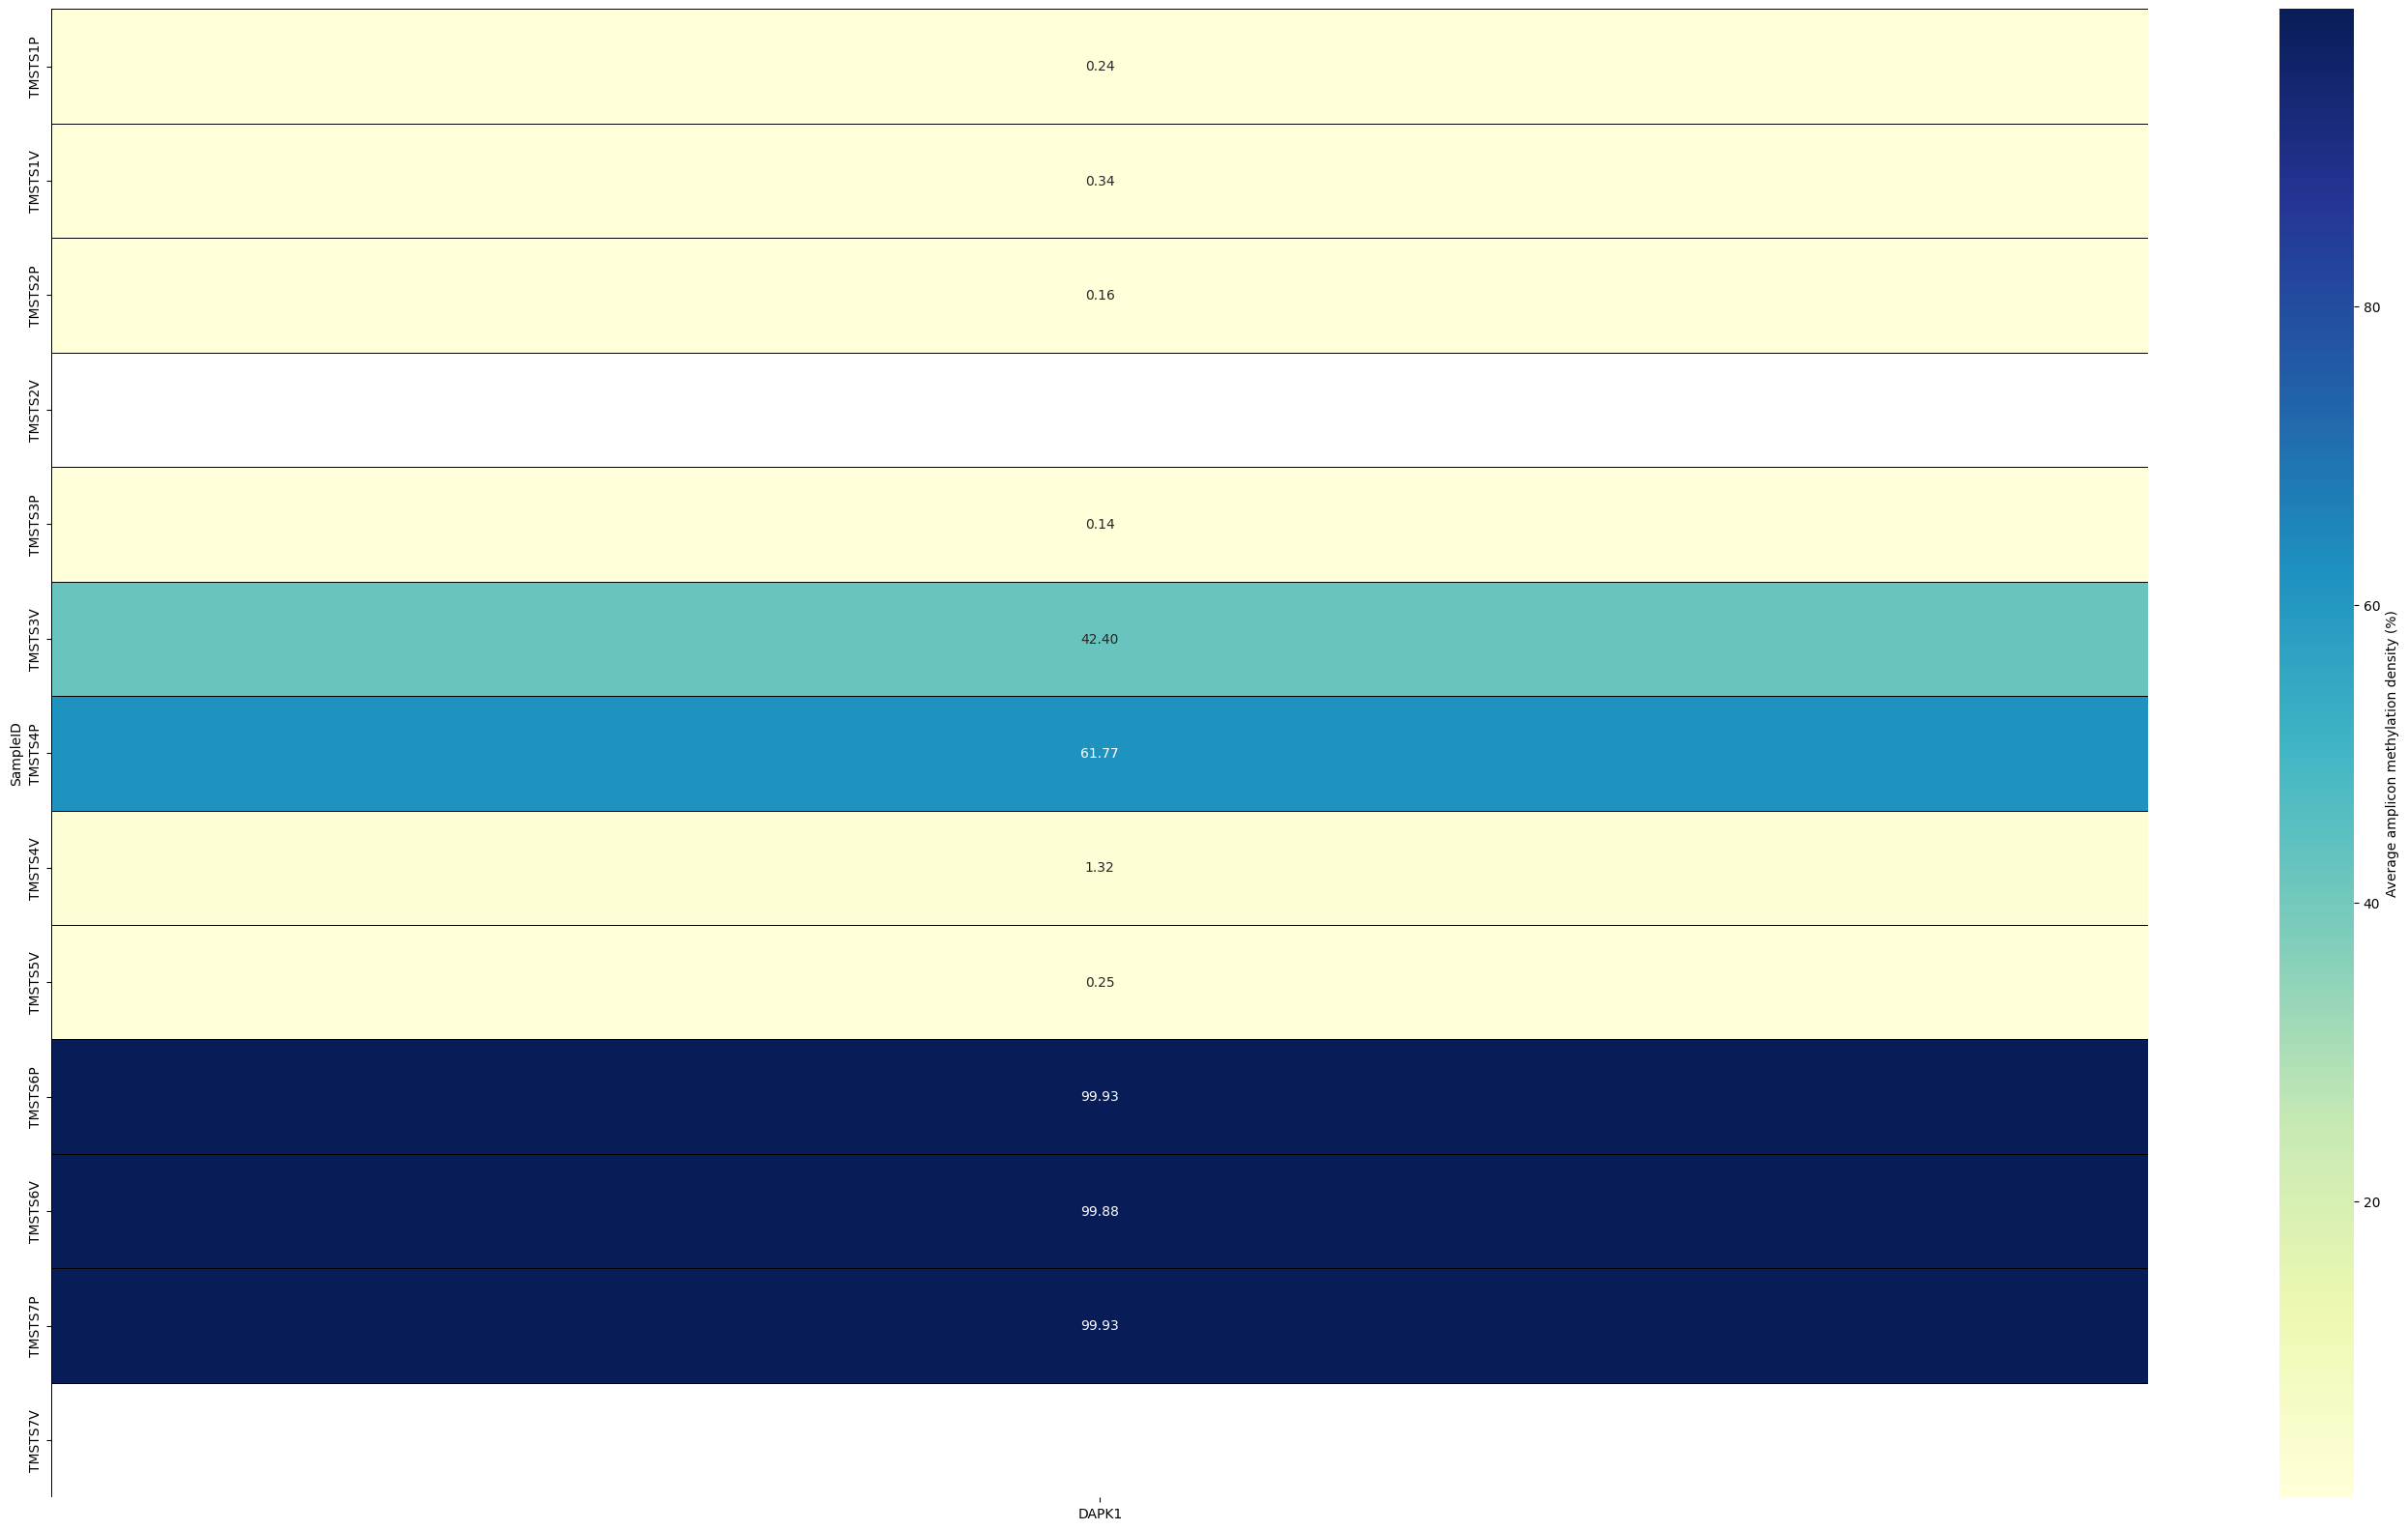

In [15]:
# if serial == True:
for run in final_umi_rundf.Run.unique():
# for run in ["R7400"]:
    if UMI == True:
        input_modes = ["UMI", "ignore_UMI"]
    else:
        input_modes = ["ignore_UMI"]
    for mode in input_modes:
        if mode == "UMI":
            plot_metadata = final_umi_rundf[(final_umi_rundf["Run"] == run) & 
                                            (final_umi_rundf["UMI_status"] == "Processed")].sort_values(by = "SampleID")
            selected_cov = "UMI_processed_cov"
            bampath = "umi_bam"
            total_col = "count_umi_bam"
        else:
            plot_metadata = final_umi_rundf[(final_umi_rundf["Run"] == run) & 
                                            (final_umi_rundf["ignore_UMI_status"] == "Processed")].sort_values(by = "SampleID")
            selected_cov = "ignore_UMI_processed_cov"
            bampath = "non_umi_bam"
            total_col = "count_non_umi_bam"

        run_panels = plot_metadata.Panel_version.unique()

        # check how many panels are available for this run
        print(f"Run {run} has {len(plot_metadata.Panel_version.unique())} panel(s), {', '.join(run_panels)}")
        
        for panel_name in run_panels:
            metadata = final_umi_rundf[(final_umi_rundf["Run"] == run) & 
                                    (final_umi_rundf["Panel_version"] == panel_name)
                                    & (final_umi_rundf[f"{mode}_status"] == "Processed")]
            panel_name = panel_name.replace(" ", "_")
            paneldf = all_paneldf[panel_name].copy()

            os.system(f"mkdir -p {os.path.join(path_to_02_output, 
                                                "methylation_matrix", 
                                                run,
                                                
                                                panel_name, 
                                                mode)}")
            if metadata.shape[0] > 1:
                methdf = pd.DataFrame()
                for sampleid in tqdm(metadata.SampleID.unique()):
                    covdf = pd.read_excel(metadata[metadata["SampleID"] == sampleid][selected_cov].values[0])
                    covdf = covdf[covdf["check_context"] == "CpG_context"]
                    tmpdf = pd.DataFrame(data = [sampleid], columns = ["SampleID"])
                    os.system(f"mkdir -p {os.path.join(path_to_02_output, "amplicon_cov", run, panel_name, mode,  sampleid)}")
                    for amplicon in covdf["amplicon"].unique():
                        amplicon_covdf = covdf[covdf["amplicon"] == amplicon].copy()
                        tmpdf[amplicon] = amplicon_covdf["meth_density"].mean()
                        if amplicon_covdf.shape[0] > 0:
                            amplicon_covdf.to_excel(os.path.join(path_to_02_output, "amplicon_cov", run, panel_name, mode,  sampleid, f"{sampleid}_{amplicon}_cov.xlsx"), index = False)
                    tmpdf.fillna(0, inplace = True)
                    methdf = pd.concat([methdf, tmpdf], axis = 0)
                methdf.sort_values(by = "SampleID", inplace = True)
                methdf.to_excel(os.path.join(path_to_02_output, 
                                                    "methylation_matrix", 
                                                    run,
                                                    panel_name, 
                                                    mode,
                                                    "avg_methylation_density_in_amplicons.xlsx"), index = False)
                plt.figure(figsize=(35, 20))
                plt.tight_layout()
                sns.heatmap(methdf.set_index("SampleID"),cmap="YlGnBu", fmt=".2f", annot=True, linewidths=.5, linecolor='black', cbar_kws={"label": "Average amplicon methylation density (%)"})
                plt.savefig(os.path.join(path_to_02_output, 
                                                    "methylation_matrix", 
                                                    run,
                                                    panel_name, 
                                                    mode,
                                                    "avg_methylation_density_in_amplicons.png"), dpi=300, bbox_inches='tight')